# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import joblib
from scipy import stats

from boruta import BorutaPy

from ydata_profiling import ProfileReport

from sklearn.utils import shuffle

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score,recall_score,brier_score_loss, classification_report
from sklearn.metrics import roc_curve,plot_confusion_matrix,confusion_matrix,f1_score,cohen_kappa_score,auc,roc_auc_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.combine import SMOTETomek

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set()

# Helper Functions

In [3]:
def ml_metrics( model_name, y, yhat):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    accuracy = accuracy_score(y, yhat)
    f1_value = f1_score(y, yhat)
    cohen_kappa_value = cohen_kappa_score(y, yhat)
    return pd.DataFrame({'Model Name': model_name, 
                        'precision': precision,
                        'recall': recall,
                        'accuracy': accuracy,
                        'f1-score': f1_value,
                        'cohen-kappa': cohen_kappa_value}, index = [0])

In [4]:
def ml_cross_validation(model_name, model, k_fold, X, y):
    folder = StratifiedKFold(n_splits = k_fold)

    measures = pd.DataFrame()
    for train_index, test_index in folder.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold,y_train_fold.values.ravel())

        y_hat = model.predict(x_test_fold)

        measure = ml_metrics( model_name, y_test_fold, y_hat)
        measures = pd.concat( [ measures, measure], axis = 0, ignore_index = True)
    return measures

In [5]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]

    # correção bias V de Cramer
    chi2corr = max(0, chi2 - (k-1)*(r - 1) / (n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    v = np.sqrt( (chi2corr / n) / (min(kcorr-1, rcorr-1) ) )
    return v

In [6]:
path = '../data/processed/'

# Load Data

In [5]:
# path = '..\\data\\raw\\'

# df = pd.read_csv(path + 'PS_20174392719_1491204439457_log.csv')
# df.head()

# df.to_parquet('..\\data\\processed\\credit_card_transaction.parquet', index = False)

In [7]:
df = pd.read_parquet(path + 'credit_card_transaction.parquet')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


## Data Dimension

In [8]:
print('Number of rows: {} \n Number of columns: {}'.format(df.shape[0], df.shape[1]))

Number of rows: 6362620 
 Number of columns: 11


## Data Types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
df.sort_values(by=['isFlaggedFraud'], ascending = False)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6296014,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.00,0.00,1,1
6362460,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.00,0.00,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.00,0.00,1,1
6362584,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.00,0.00,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.00,0.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2120869,183,CASH_IN,118980.42,C1325911476,1704431.57,1823411.99,C257232928,2001605.12,1882624.70,0,0
2120868,183,CASH_IN,203094.44,C24786701,1501337.12,1704431.57,C316761923,8095303.60,7892209.15,0,0
2120867,183,CASH_IN,174346.32,C1795889203,1326990.80,1501337.12,C547359094,276757.88,102411.55,0,0
2120866,183,CASH_IN,67507.70,C1035027223,1259483.10,1326990.80,C1730848226,94625.84,27118.13,0,0


## Check NA

In [11]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Descriptive Statistics

In [12]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(include=['object'])

## Numerical Attributes

In [13]:
min_v = pd.DataFrame(num_attributes.apply( np.min )).T
max_v = pd.DataFrame(num_attributes.apply( np.max )).T
mean_v = pd.DataFrame(num_attributes.apply( np.mean )).T
median_v = pd.DataFrame(num_attributes.apply( np.median )).T
std_v = pd.DataFrame(num_attributes.apply( np.std )).T
skew_v = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
kurtosis_v = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

results = pd.concat( [ min_v, max_v, mean_v, median_v, std_v, skew_v, kurtosis_v]).T.reset_index()
results.columns = ['attributes','min','max','mean','median','std','skew','kurtosis']
results

,attributes,min,max,mean,median,std,skew,kurtosis
0,step,1.00,743.00,243.40,239.00,142.33,0.38,0.33
1,amount,0.00,92445516.64,179861.90,74871.94,603858.18,30.99,1797.96
2,oldbalanceOrg,0.00,59585040.37,833883.10,14208.00,2888242.45,5.25,32.96
3,newbalanceOrig,0.00,49585040.37,855113.67,0.00,2924048.27,5.18,32.07
4,oldbalanceDest,0.00,356015889.35,1100701.67,132705.66,3399179.85,19.92,948.67
5,newbalanceDest,0.00,356179278.92,1224996.40,214661.44,3674128.65,19.35,862.16
6,isFraud,0.00,1.00,0.00,0.00,0.04,27.78,769.70
7,isFlaggedFraud,0.00,1.00,0.00,0.00,0.00,630.60,397659.06


In [17]:
df_fraud = df.loc[df['isFraud'] == 1]
df_non_fraud = df.loc[df['isFraud'] == 0]

## Log evaluation

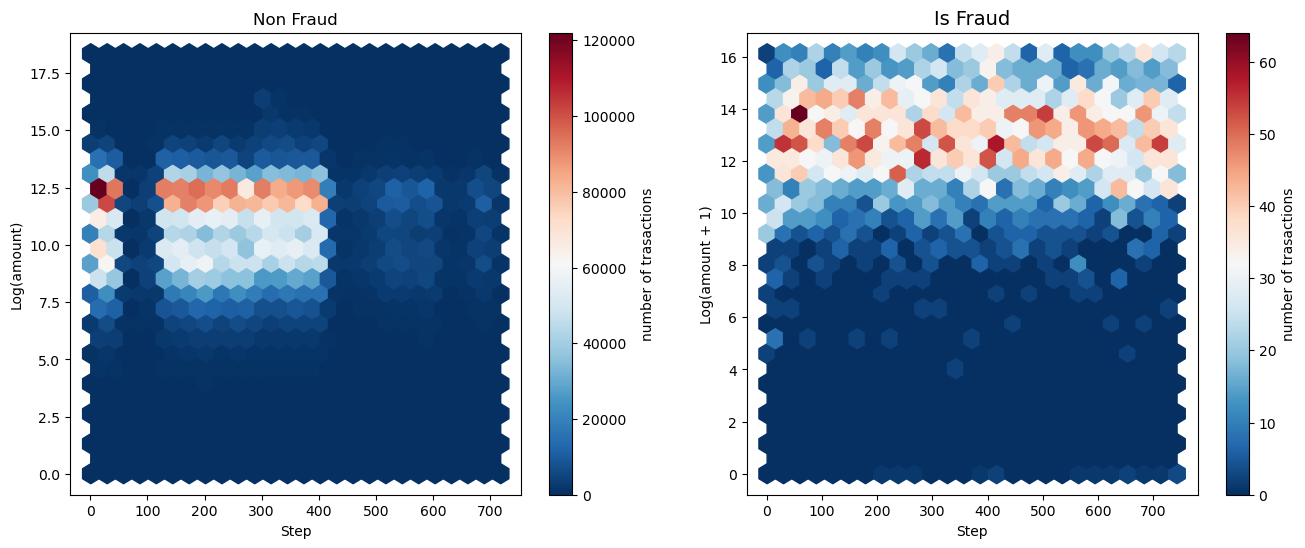

In [20]:
# amount has a long range. So, we gonna try to use log to change this scale
x = 'step'
y = 'amount'
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.hexbin(df_non_fraud[x],np.log1p(df_non_fraud[y]), gridsize = 25, cmap = 'RdBu_r')
plt.title('Non Fraud', fontsize=12)
plt.xlabel('Step')
plt.ylabel('Log(amount)')
count_bar = plt.colorbar()
count_bar.set_label('number of trasactions')

# plots for the cases of fraud
plt.subplot(1,2,2)
plt.hexbin(df_fraud[x], np.log1p(df_fraud[y]), gridsize=25, cmap='RdBu_r')
plt.title("Is Fraud", fontsize=14)
plt.xlabel("Step")
plt.ylabel("Log(amount + 1)")
count_bar = plt.colorbar()
count_bar.set_label('number of trasactions')

# adjusts the spaces between plots
plt.subplots_adjust(wspace=0.2)

# displays the plot
plt.show()

As observed, for the non fraudulent transactions, we have some outliers between step == 500 and step == 700. For the fraudulent transactions, we have to look at the amount.

## Quantil eval

 As we observed in the previous section, there are outliers in the data set. We're going to check which values can be considered as outliers by calculating the Q1, Q3 and IQR.

In [21]:
q1 = np.log1p(df_fraud['amount'].quantile(.25))
q3 = np.log1p(df_fraud['amount'].quantile(.75))
iqr = q3 - q1
low_boundary = round(q1 - (1.5 * iqr),5)
high_boundary = round(q3 + (1.5 * iqr),5)
print('Boundaries:\nQ1: {}\nQ2: {}\nIQR:{}'.format(q1,q3,iqr))
print('For fraudulent transactions we have these values for AMOUNT...\n LOW: {} and HIGH: {}'.format(low_boundary, high_boundary))

Boundaries:
Q1: 11.752669109172535
Q2: 14.232754344281444
IQR:2.480085235108909
For fraudulent transactions we have these values for AMOUNT...
 LOW: 8.03254 and HIGH: 17.95288


In [24]:
# fig, axes = plt.subplots(1,2,figsize=(16,8))

# sns.distplot(a = df_non_fraud['amount'], ax = axes[0]);
# sns.distplot(a =  np.log1p(df_non_fraud['amount']), ax = axes[1]);
# axes[0].set_title('Amount (RAW)');
# axes[1].set_title('Amount (LOG)');

In [25]:
q1 = df_non_fraud['step'].quantile(.25)
q3 = df_non_fraud['step'].quantile(.75)
iqr = q3 - q1
low_boundary = q1 - (1.5 * iqr)
high_boundary = q3 + (1.5 * iqr)
print('Boundaries:\nQ1: {}\nQ2: {}\nIQR:{}'.format(q1,q3,iqr))
print('For non-fraudulent transactions we have these values for STEP...\n LOW: {} and HIGH: {}'.format(low_boundary, high_boundary))

Boundaries:
Q1: 156.0
Q2: 334.0
IQR:178.0
For non-fraudulent transactions we have these values for STEP...
 LOW: -111.0 and HIGH: 601.0


## Categorical Attributes

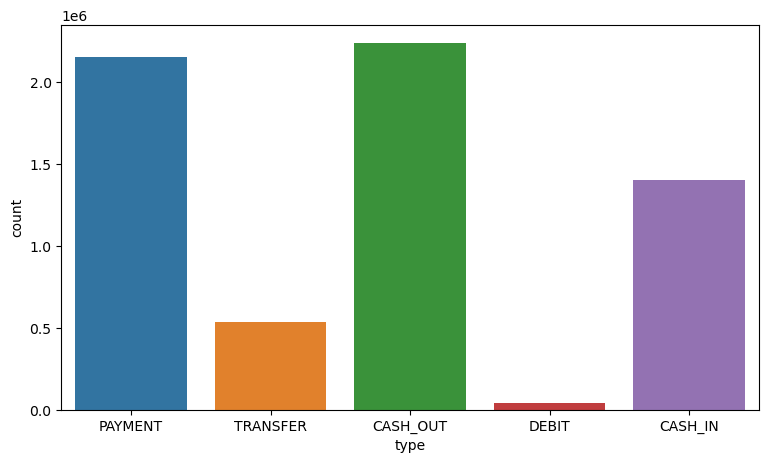

In [49]:
fig, axes = plt.subplots(1,1,figsize=(9,5))
sns.countplot(data = df,x = 'type', ax = axes);
plt.show();

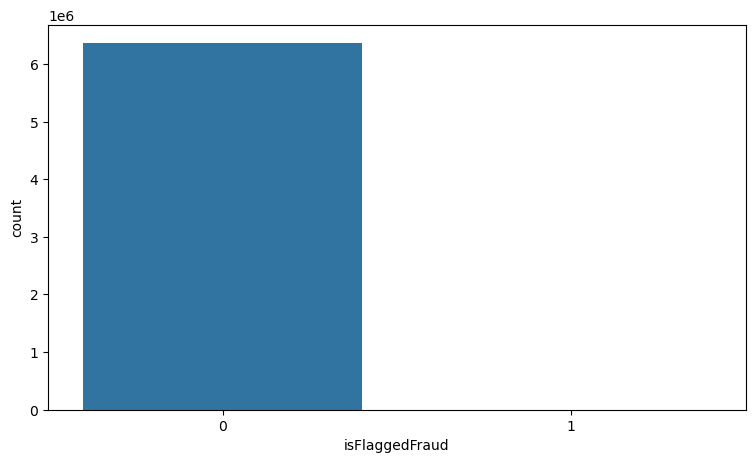

In [53]:
fig, axes = plt.subplots(1,1,figsize=(9,5))
sns.countplot(data = df,x = 'isFlaggedFraud', ax = axes);
plt.show();

# Data Filtering

In [26]:
df_non_fraud_no = df_non_fraud.loc[df_non_fraud['step'] < 601]
df_fraud_no = df_fraud.loc[~( df_fraud['amount'] < np.expm1( 8.032541256509171) ) ]

In [27]:
df_no = pd.concat([df_non_fraud_no, df_fraud_no], axis = 0)

df_no = shuffle(df_no)

df_no.reset_index(drop=True, inplace=True)

In [28]:
ratio_out = round(100 * (df.shape[0] - df_no.shape[0]) / df.shape[0], 2)
print('Ratio of outliers: {} %'.format(ratio_out))

Ratio of outliers: 1.6 %


In [29]:
df_no.to_parquet('../data/processed/credit_card_transaction_without_outliers.parquet', index = False)

In [15]:
df_no = pd.read_parquet('../data/processed/credit_card_transaction_without_outliers.parquet')

# Feature Engineering

In [7]:
df1 = pd.read_parquet(path + 'credit_card_transaction_without_outliers.parquet')

Features to create:
- `transaction_direction`: (C2C,C2M,M2M,M2C)
- `hour`: equivalent to STEP
- `orig_type` (customer or machine)
- `dest_type` (customer or machine)
- `old_balance_orig_status` (zero or non zero)
- `new_balance_orig_status` (zero or non zero)
- `old_balance_dest_status` (zero or non zero)
- `new_balance_dest_status` (zero or non zero)
- `is_orig_old_balance_greater_new` (yes or no)
- `is_dest_old_balance_greater_new` (yes or no)
- `is_orig_equal_dest` (yes or no)


In [8]:
df1.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,210,PAYMENT,17933.72,C1228332070,22075.89,4142.16,M1614268800,0.00,0.00,0,0
1,347,CASH_IN,429558.69,C1180977962,3814609.43,4244168.12,C445759639,450414.15,20855.46,0,0
2,206,TRANSFER,233335.54,C926393142,94434.63,0.00,C305189339,1517958.43,1751293.98,0,0


In [9]:
# orig_type
df1['orig_type'] = 'customer'
df1.loc[df1['nameOrig'].str.contains('M'), 'orig_type'] = 'machine'

# dest_type
df1['dest_type'] = 'customer'
df1.loc[df1['nameDest'].str.contains('M'), 'dest_type'] = 'machine'

# old_balance_orig_status
df1['old_balance_orig_status'] = 'zero'
df1.loc[df1['oldbalanceOrg'] != 0, 'old_balance_orig_status'] = 'non zero'

# new_balance_orig_status
df1['new_balance_orig_status'] = 'zero'
df1.loc[df1['newbalanceOrig'] != 0, 'new_balance_orig_status'] = 'non zero'

# old_balance_dest_status
df1['old_balance_dest_status'] = 'zero'
df1.loc[df1['oldbalanceDest'] != 0, 'old_balance_dest_status'] = 'non zero'

# new_balance_dest_status
df1['new_balance_dest_status'] = 'zero'
df1.loc[df1['newbalanceDest'] != 0, 'new_balance_dest_status'] = 'non zero'

# is_orig_old_balance_greater_new
df1['is_orig_old_balance_greater_new'] = 'yes'
df1.loc[df1['newbalanceOrig'] < df1['oldbalanceOrg'], 'is_orig_old_balance_greater_new'] = 'no'

# is_dest_old_balance_greater_new
df1['is_dest_old_balance_greater_new'] = 'yes'
df1.loc[df1['newbalanceDest'] < df1['oldbalanceDest'], 'is_dest_old_balance_greater_new'] = 'no'

# transaction_direction
df1['transaction_direction'] = 'C2C'
df1.loc[(df1['orig_type'] == 'customer') & (df1['dest_type'] == 'machine'), 'transaction_direction'] = 'C2M'
df1.loc[(df1['orig_type'] == 'machine') & (df1['dest_type'] == 'customer'), 'transaction_direction'] = 'M2C'
df1.loc[(df1['orig_type'] == 'machine') & (df1['dest_type'] == 'machine'), 'transaction_direction'] = 'M2M'


# is_orig_equal_dest
for i in ['nameOrig','nameDest']:
    df1[i] = df1[i].astype(str).str.strip()
df1['is_orig_equal_dest'] = 'yes'
df1.loc[df1['nameOrig'] != df1['nameDest'], 'is_orig_equal_dest'] = 'no'

In [11]:
# hour

# create a dataframe to refer the correct hour of the day
qty_iter = int((df1['step'].max() - df1['step'].min()) / 24)

rel_step_hour = pd.DataFrame()

list_hour_day = list(np.arange(24))
list_days = list(np.arange(24))

for i in range(qty_iter):
    list_hour_day = list_hour_day + list_days

rel_step_hour = pd.DataFrame(list_hour_day, columns = ['hour'])
rel_step_hour['step'] = np.arange(1,len(rel_step_hour) + 1)

,hour,step
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
...,...,...
739,19,740
740,20,741
741,21,742
742,22,743


In [12]:
print(df1.shape)

df1 = df1.merge(rel_step_hour,on = ['step'], how = 'inner')

print(df1.shape)

(6260531, 21)
(6260531, 22)


In [ ]:
# # proportion between the amount and oldBalance
# df['proportionBalance'] = round(100 * ((df['newbalanceOrig'] - df['oldbalanceOrg']) / df['oldbalanceOrg']), 2)
# df.replace([np.nan,np.inf,-np.inf], 0, inplace = True)
# df.head()

In [13]:
df1.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_type,dest_type,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new,transaction_direction,is_orig_equal_dest,hour
0,210,PAYMENT,17933.72,C1228332070,22075.89,4142.16,M1614268800,0.00,0.00,0,0,customer,machine,non zero,non zero,zero,zero,no,yes,C2M,no,17
1,210,PAYMENT,8962.15,C205765780,80393.00,71430.85,M1494168155,0.00,0.00,0,0,customer,machine,non zero,non zero,zero,zero,no,yes,C2M,no,17
2,210,PAYMENT,13227.30,C54687277,242284.26,229056.97,M1115841173,0.00,0.00,0,0,customer,machine,non zero,non zero,zero,zero,no,yes,C2M,no,17


In [15]:
for i in ['isFraud','isFlaggedFraud','orig_type','dest_type']:
    print(df1[i].value_counts())
    print('\n')

0    6252434
1       8097
Name: isFraud, dtype: int64


0    6260515
1         16
Name: isFlaggedFraud, dtype: int64


customer    6260531
Name: orig_type, dtype: int64


customer    4144177
machine     2116354
Name: dest_type, dtype: int64




In [17]:
for i in ['old_balance_orig_status','new_balance_orig_status','old_balance_dest_status','new_balance_dest_status']:
    print(df1[i].value_counts(normalize = True))
    print('\n')

non zero   0.67
zero       0.33
Name: old_balance_orig_status, dtype: float64


zero       0.57
non zero   0.43
Name: new_balance_orig_status, dtype: float64


non zero   0.58
zero       0.42
Name: old_balance_dest_status, dtype: float64


non zero   0.62
zero       0.38
Name: new_balance_dest_status, dtype: float64




In [18]:
for i in ['is_orig_old_balance_greater_new','is_dest_old_balance_greater_new','transaction_direction','is_orig_equal_dest']:
    print(df1[i].value_counts(normalize = True))
    print('\n')

yes   0.55
no    0.45
Name: is_orig_old_balance_greater_new, dtype: float64


yes   0.81
no    0.19
Name: is_dest_old_balance_greater_new, dtype: float64


C2C   0.66
C2M   0.34
Name: transaction_direction, dtype: float64


no   1.00
Name: is_orig_equal_dest, dtype: float64




In [ ]:
df1.to_parquet(path + 'credit_card_transaction_without_outliers_fe.parquet', index = False)

# Hipothesis

> Transaction Type
1. Payment represent 50% of the total fraudulent transactions.
2. Transfer represent 50% of the total non fraudulent transactions.

> Transaction Direction
1. Customer to Machine represent at least 50% of the total fraudulent transactions.
2. Customer to Customer represent at least 50% of the total non fraudulent transactions.

> Transaction Destination
1. Machine destination represents 40% of the total fraudulent transactions.
2. Customer destination represents 40% of the total non fraudulent transactions.
3. Destination non zero new balance represents 50% of the total fraudulent transactions.

> Transaction Origin
1. Origin non zero old balance represents 80% of the total fraudulent transactions.
2. Origin zero new balance represents 40% of the total fraudulent transactions.

> Flagged as fraud
1. At least 95% of the total fraudulent transactions are flagged as fraud.
2. At least 20% of the total non fraudulent transactions are flagged as fraud.

# EDA

In [7]:
try:
    df2 = df1.copy()
except:
    df2 = pd.read_parquet(path + 'credit_card_transaction_without_outliers_fe.parquet')

## Univariate Analysis

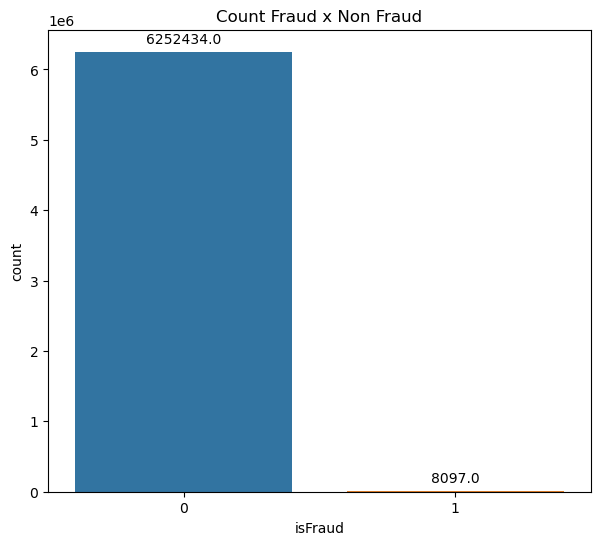

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(7,6))

sns.countplot(x= df2['isFraud'], ax = axes);
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.1f'),
                  (p.get_x() + p.get_width() / 2.,p.get_height()),
                  ha= 'center', va = 'center',xytext=(0,9), textcoords='offset points')
axes.set_title('Count Fraud x Non Fraud', fontsize = 12)
plt.show();

In [9]:
# gets the numerical attributes
numerical_att = df2[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']]

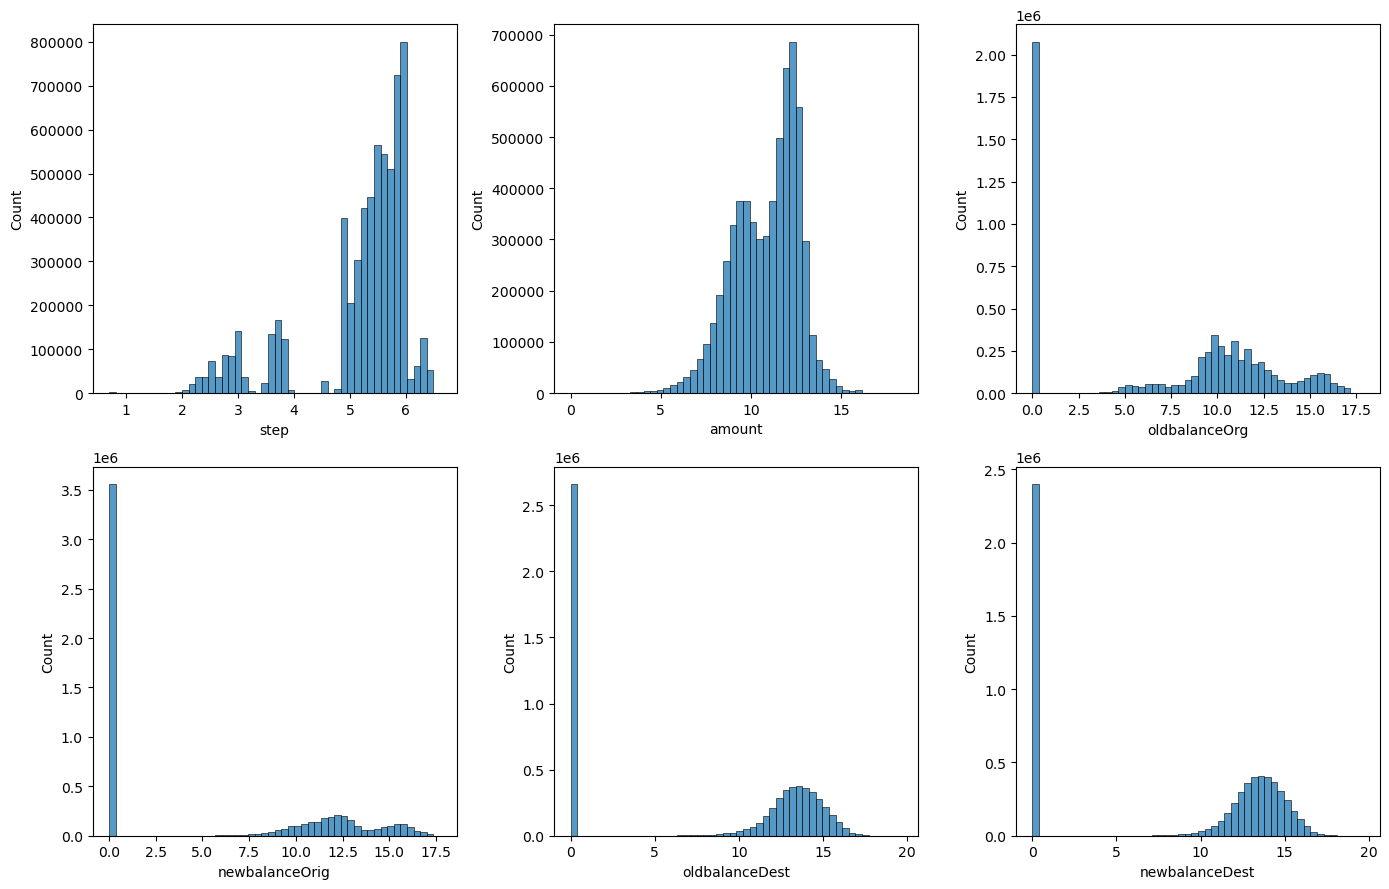

In [10]:
# sets the plot size
plt.figure(figsize=(14,9))

# sets the initial plot position
n = 1

# iterate over the columns to plot
for column in numerical_att.columns:
    plt.subplot(2,3,n)
    _ = sns.histplot(x=np.log1p(numerical_att[column]), bins=50)
    n += 1

plt.tight_layout()

In [11]:
# inverse log transform: amount
print(f'AMOUNT higher concentration: between {round(np.expm1(11), 2)} and {round(np.expm1(13), 2)}')

# inverse log transform: old_balance_orig
print(f'Origin old balance minor concentration: between {round(np.expm1(9), 2)} and {round(np.expm1(12), 2)}')

# inverse log transform: new_balance_orig
print(f'Origin new balance minor concentration: between {round(np.expm1(11.5), 2)} and {round(np.expm1(13), 2)}')

# inverse log transform: old_balance_dest
print(f'Destination old balance minor concentration: between {round(np.expm1(12.5), 2)} and {round(np.expm1(14.5), 2)}')

# inverse log transform: new_balance_dest
print(f'Destination new balance minor concentration: between {round(np.expm1(12.5), 2)} and {round(np.expm1(14.5), 2)}')

AMOUNT higher concentration: between 59873.14 and 442412.39
Origin old balance minor concentration: between 8102.08 and 162753.79
Origin new balance minor concentration: between 98714.77 and 442412.39
Destination old balance minor concentration: between 268336.29 and 1982758.26
Destination new balance minor concentration: between 268336.29 and 1982758.26


> Balance, such as Orig and Dest, is concentrated in ZERO;

> Amount is concentrated between 59,873.14 and 442,412.39

In [12]:
# gets the category  attributes
cat_cols = ['type','isFlaggedFraud', 'orig_type', 'dest_type', 'old_balance_orig_status',
       'new_balance_orig_status', 'old_balance_dest_status',
       'new_balance_dest_status', 'is_orig_old_balance_greater_new',
       'is_dest_old_balance_greater_new', 'transaction_direction',
       'is_orig_equal_dest']
cat_att = df2[cat_cols]
len(cat_att.columns)

12

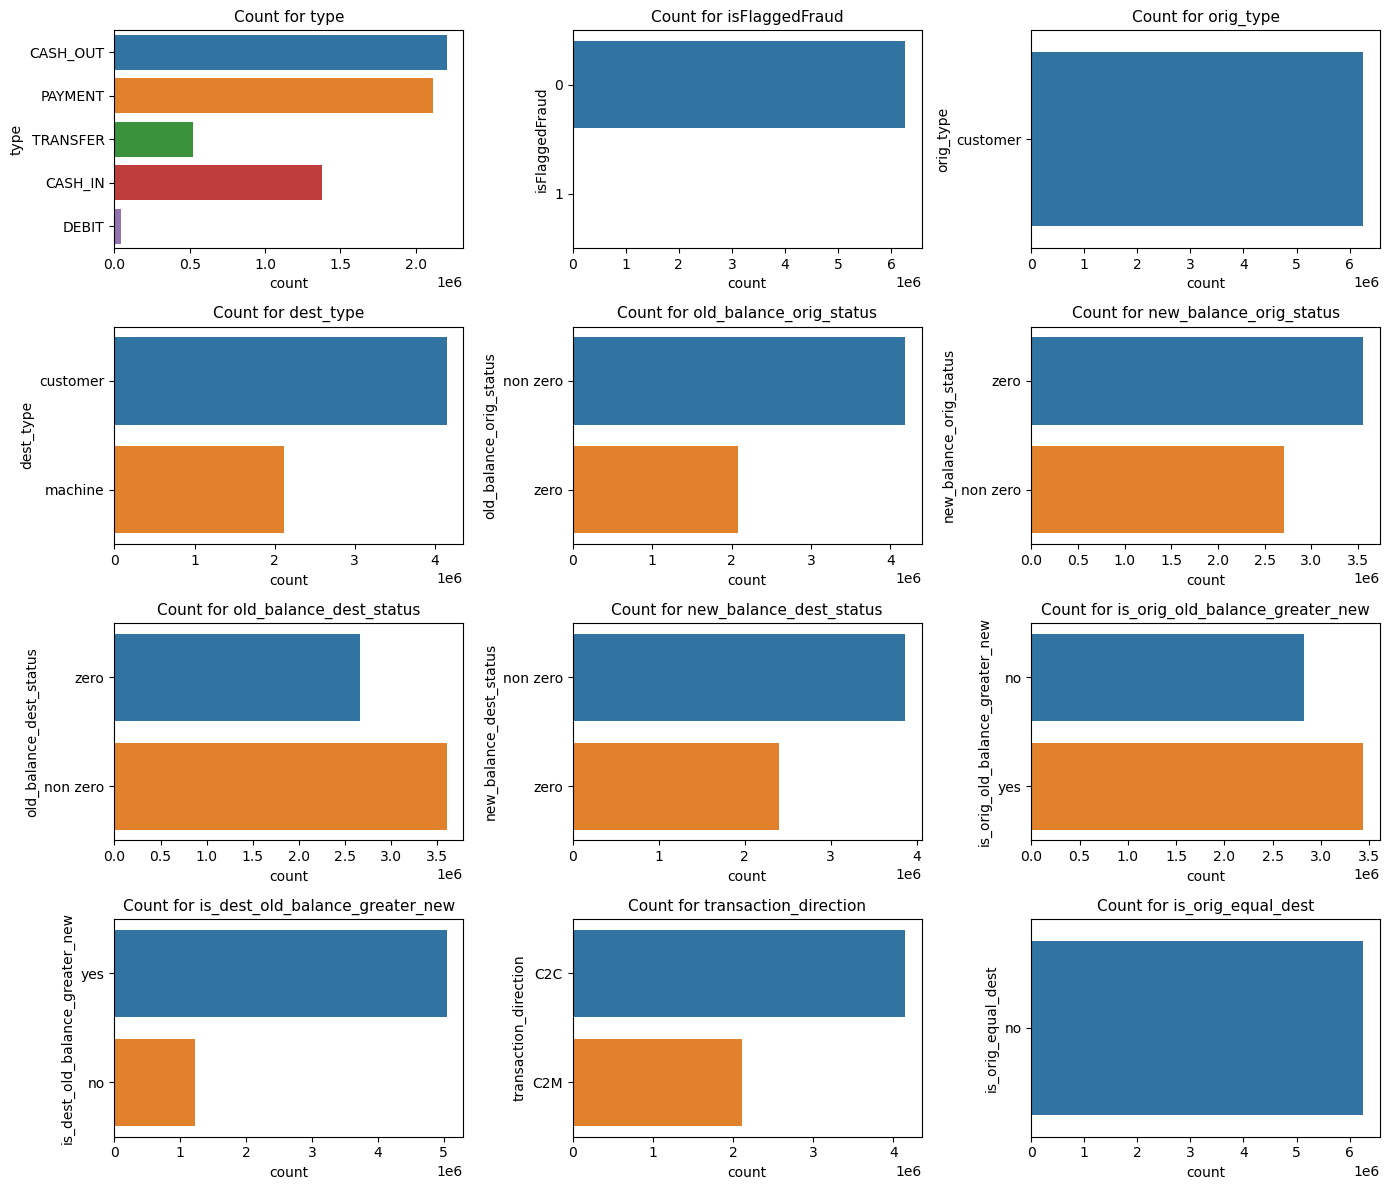

In [13]:
# sets the plot size
plt.figure(figsize=(14,12))

# sets the initial plot position
n = 1

# iterate over the columns to plot
for column in cat_att.columns:
    plt.subplot(4,3,n)
    _ = sns.countplot(y=cat_att[column])
    plt.title("Count for " + column, fontsize=11)
    n += 1

plt.tight_layout();
plt.show()

Key points:

- Cash-out and payment represent the major part of the total transactions.
- The great majority of the transactions are not flagged as fraud.
- There is only one type of origin: customer.
- There are more transactions whose destination is customer.
- The origin old balance status is non zero for the majority of transactions.
- There are more transactions whose the origin new balance status is zero.
- There are more transactions whose the destination old balance status is non zero.
- There are more transactions whose the destination new balance status is non zero.
- No transactions has the the same origin as destination.
- There are more transactions whose origin old balance is higher than the new.
- The destination old balance is higher than the new for the majority of the transctions.
- The transaction direction C2C is almost the double of C2M.

In [14]:
num_orig_uq = len(df2['nameOrig'].unique())
num_dest_uq = len(df2['nameDest'].unique())

In [15]:
ratio_orig_all = round(100*num_orig_uq / df_no.shape[0],3)
ratio_dest_all = round(100*num_dest_uq / df_no.shape[0],3)

print('Number of unique OrigName: {} and Proportion compared with all dataset: {} %'.format(num_orig_uq,ratio_orig_all))
print('Number of unique DestName: {} and Proportion compared with all dataset: {} %'.format(num_dest_uq,ratio_dest_all))

Number of unique OrigName: 6251489 and Proportion compared with all dataset: 99.856 %
Number of unique DestName: 2677202 and Proportion compared with all dataset: 42.763 %


In [16]:
# fig, axes = plt.subplots(4, 1, figsize=(16,20))

# sns.histplot(data = df1.loc[df1['type'] == 'PAYMENT'], x = 'amount', hue = 'isFraud', ax = axes[0], bins = 50);
# sns.histplot(data = df1.loc[df1['type'] == 'TRANSFER'], x = 'amount', hue = 'isFraud', ax = axes[1], bins = 50);
# sns.histplot(data = df1.loc[df1['type'] == 'CASH_IN'], x = 'amount', hue = 'isFraud', ax = axes[2], bins = 50);
# sns.histplot(data = df1.loc[df1['type'] == 'CASH_OUT'], x = 'amount', hue = 'isFraud', ax = axes[3], bins = 50);
# axes[0].set_title('PAYMENT');
# axes[1].set_title('TRANSFER');
# axes[2].set_title('CASH_IN');
# axes[3].set_title('CASH_OUT');
# plt.tight_layout()

In [17]:
# fig, axes = plt.subplots(3, 1, figsize=(16,16))
# aux = df1.loc[ df1['type'].isin( ['TRANSFER','CASH_OUT'] ) ]

# sns.histplot(data = aux, x = 'amount', hue = 'isFraud', ax = axes[0], bins = 50);
# sns.histplot(data = aux.loc[aux['isFraud'] == 0 ], x='amount', hue = 'isFraud', ax = axes[1], bins = 50);
# sns.histplot(data = aux.loc[aux['isFraud'] == 1 ], x='amount', hue = 'isFraud', ax = axes[2], bins = 50);
# axes[0].set_title('Only - Transfer/CashOut');
# axes[1].set_title('isFraud = 0');
# axes[2].set_title('isFraud = 1');
# plt.tight_layout()

## Bivariate Analysis

In [18]:
df_fraud = df2.loc[df2['isFraud'] == 1]
df_non_fraud = df2.loc[df2['isFraud'] == 0]

### H1. Payment represent 50% of the total fraudulent transactions.

CASH_OUT   0.50
TRANSFER   0.50
Name: type, dtype: float64


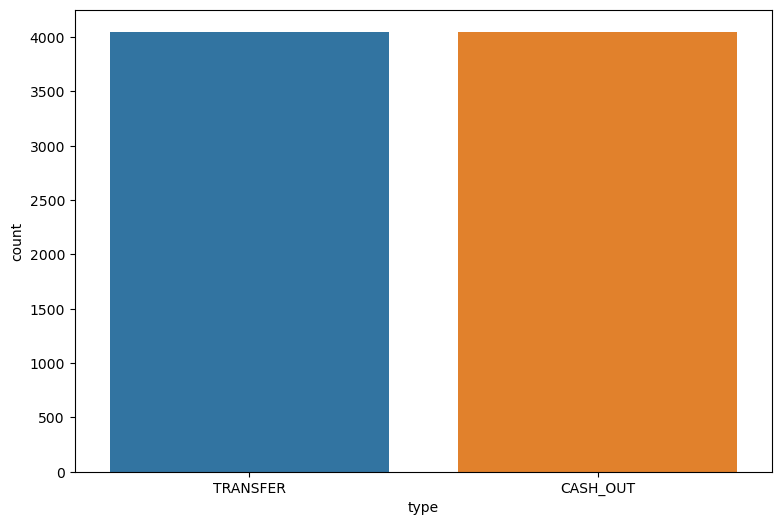

In [19]:
plt.figure(figsize=(9,6))
print(df_fraud['type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'type')
plt.show();

##### FALSE: Payment is much less than 50%

### H2. Transfer represent 50% of the total non fraudulent transactions.

CASH_OUT   0.35
PAYMENT    0.34
CASH_IN    0.22
TRANSFER   0.08
DEBIT      0.01
Name: type, dtype: float64


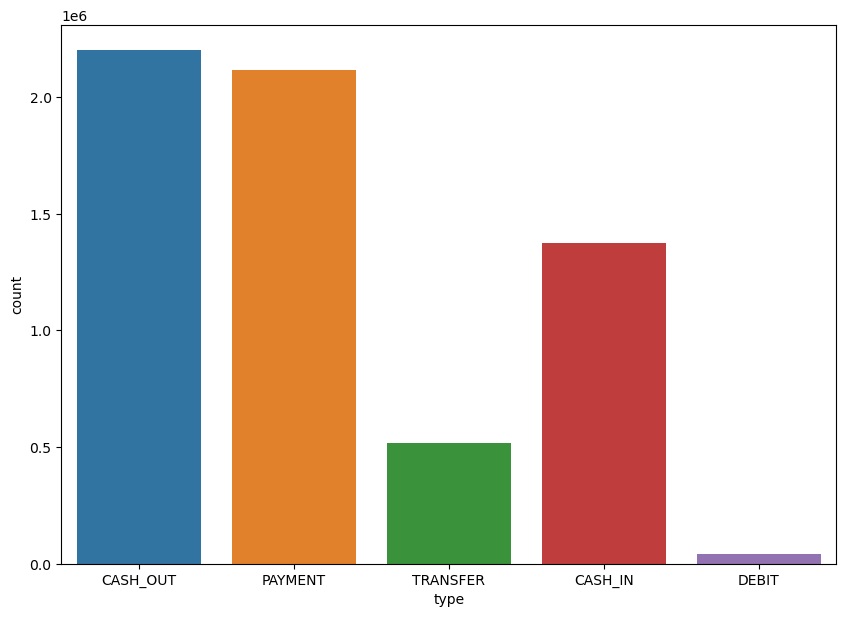

In [20]:
plt.figure(figsize=(10,7))
print(df_non_fraud['type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'type')
plt.show();

#### FALSE: Payment is much less than 50% of non fraudulent transactions

### H3. Customer to Machine represent at least 50% of the total fraudulent transactions.

C2C   1.00
Name: transaction_direction, dtype: float64


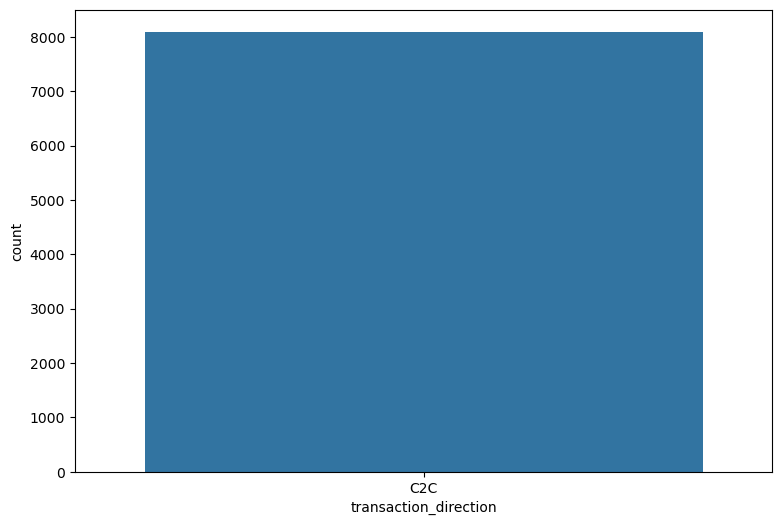

In [21]:
plt.figure(figsize=(9,6))
print(df_fraud['transaction_direction'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'transaction_direction')

plt.show();

#### FALSE: In fraudulent transactions, only C2C is present (100%)

### H4. Customer to Customer represent at least 50% of the total non fraudulent transactions.

C2C   0.66
C2M   0.34
Name: transaction_direction, dtype: float64


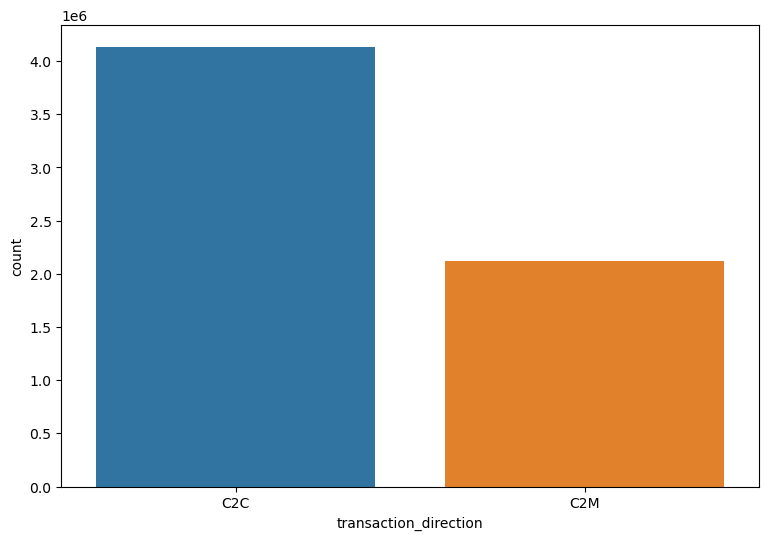

In [22]:
plt.figure(figsize=(9,6))
print(df_non_fraud['transaction_direction'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'transaction_direction')

plt.show();

#### TRUE: C2C in non fraudulent transactions has 66%

### H5. Merchant destination represents 40% of the total fraudulent transactions.

customer   1.00
Name: dest_type, dtype: float64


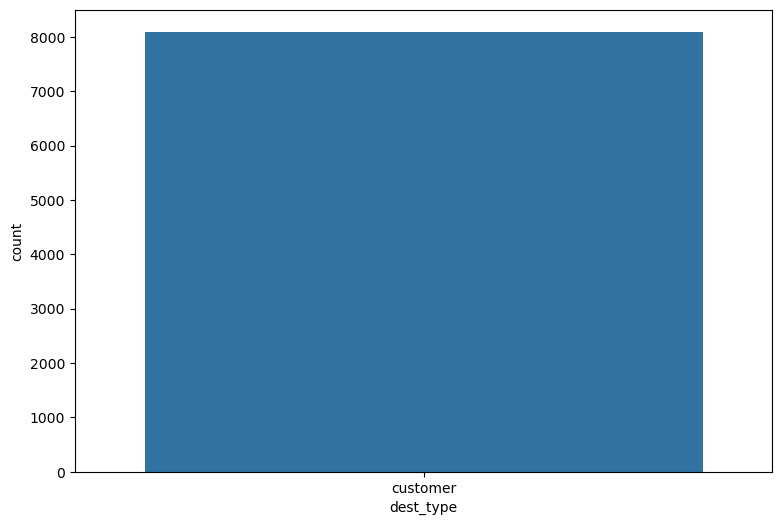

In [23]:
plt.figure(figsize=(9,6))
print(df_fraud['dest_type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'dest_type')

plt.show();

#### FALSE: Customer represents 100% of the type of destination

### H6. Customer destination represents 40% of the total non fraudulent transactions.

customer   0.66
machine    0.34
Name: dest_type, dtype: float64


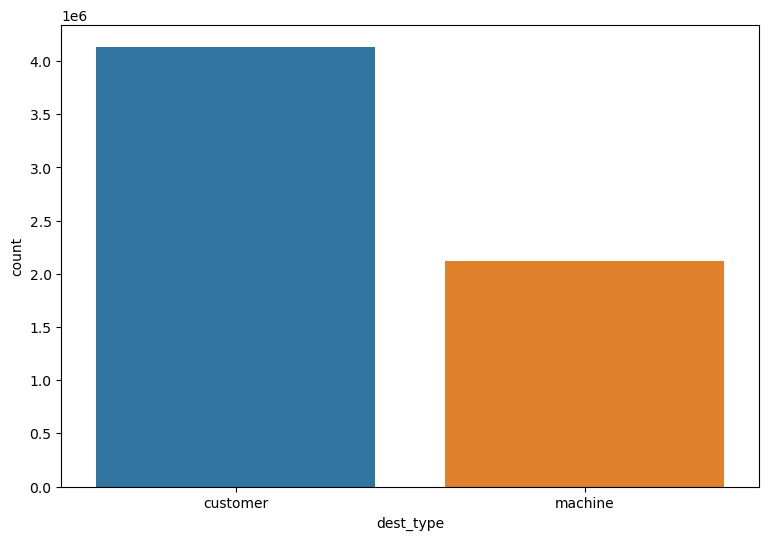

In [24]:
plt.figure(figsize=(9,6))
print(df_non_fraud['dest_type'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'dest_type')

plt.show();

#### FALSE: Customer destination of non fraudulent represents ~66%

### H7. Destination non zero new balance represents 50% of the total fraudulent transactions.

non zero   0.50
zero       0.50
Name: new_balance_dest_status, dtype: float64


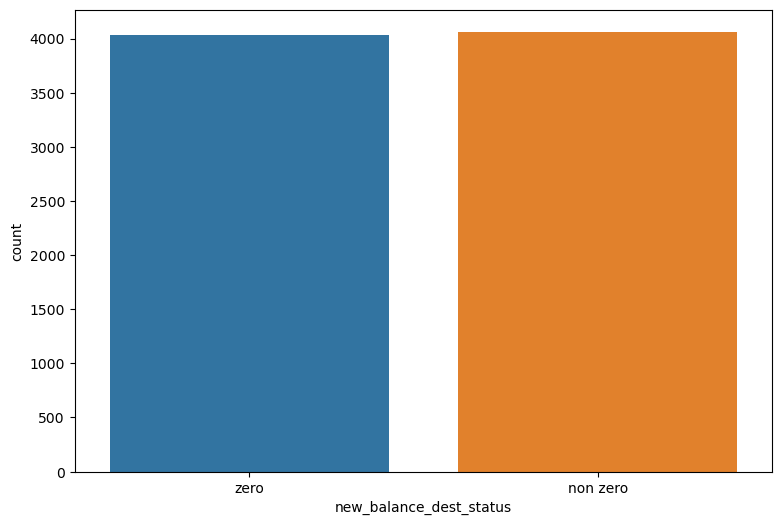

In [25]:
plt.figure(figsize=(9,6))
print(df_fraud['new_balance_dest_status'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'new_balance_dest_status')

plt.show();

#### TRUE: Destination balance with non zero represents 50% of all fraudulent transactions

### H8. Origin non zero old balance represents 80% of the total fraudulent transactions.


non zero   1.00
zero       0.00
Name: old_balance_orig_status, dtype: float64


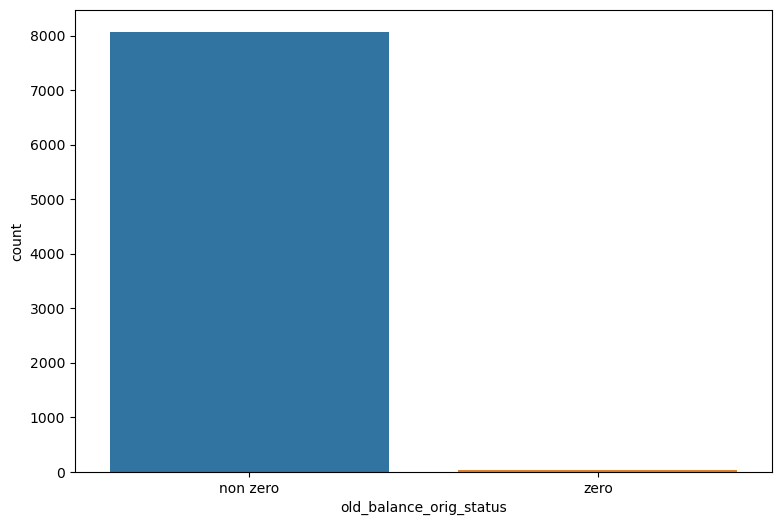

In [26]:
plt.figure(figsize=(9,6))
print(df_fraud['old_balance_orig_status'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'old_balance_orig_status')

plt.show();

#### FALSE: non zero old balance origin represents almost 100%

### H9. Origin zero new balance represents 40% of the total fraudulent transactions.

zero       0.98
non zero   0.02
Name: new_balance_orig_status, dtype: float64


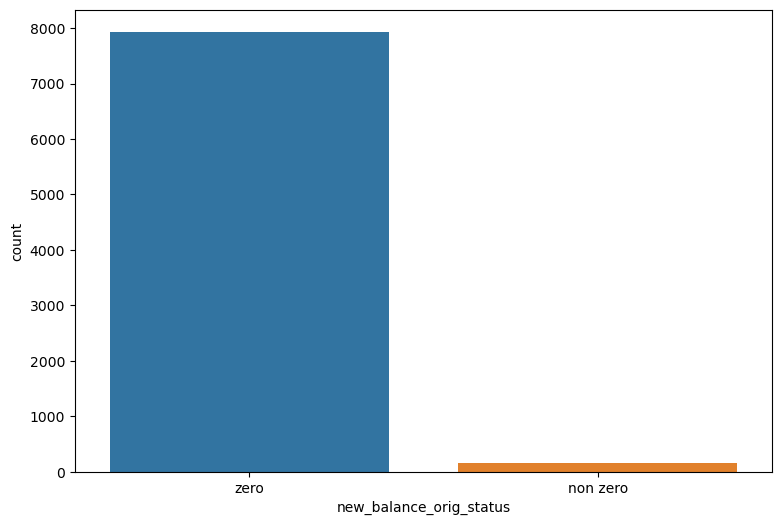

In [27]:
plt.figure(figsize=(9,6))
print(df_fraud['new_balance_orig_status'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'new_balance_orig_status')

plt.show();

#### FALSE: origin new balance status ZERO represents almost 100%

### H10. At least 95% of the total fraudulent transactions are flagged as fraud.

0   1.00
1   0.00
Name: isFlaggedFraud, dtype: float64


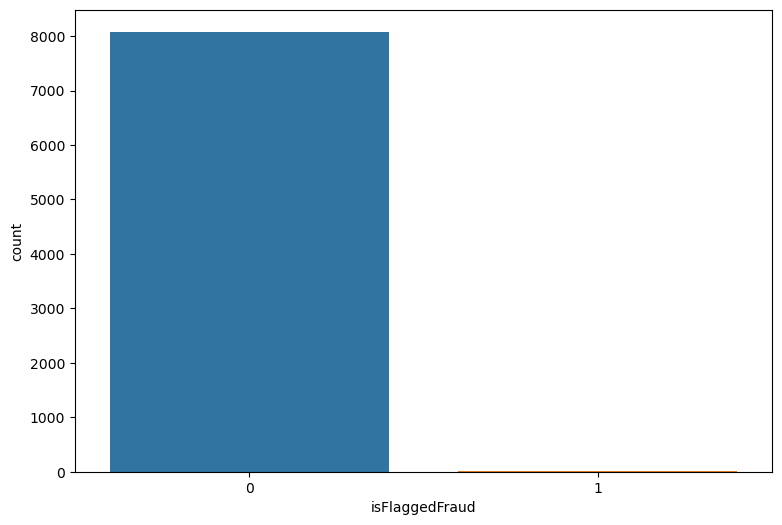

In [28]:
plt.figure(figsize=(9,6))
print(df_fraud['isFlaggedFraud'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_fraud, x = 'isFlaggedFraud')

plt.show();

#### FALSE: isFlaggedFraud is almost 100%, not 95%

### H11. At least 20% of the total non fraudulent transactions are flagged as fraud.

0   1.00
Name: isFlaggedFraud, dtype: float64

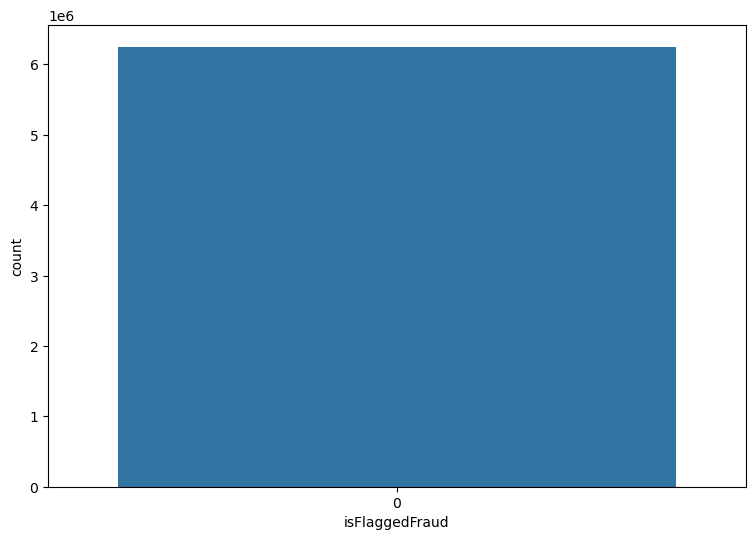

In [29]:
plt.figure(figsize=(9,6))
print(df_non_fraud['isFlaggedFraud'].value_counts(normalize = True))

plt.subplot(1,1,1)
sns.countplot(data = df_non_fraud, x = 'isFlaggedFraud')

plt.show();

#### FALSE: almost 100% of all transactions are flagged as non fraud

### Hypothesis Summary

| ID  | Hypothesis                                                                                 | Conclusion |
|:-----:|:-----------------------------------------------------------------------------------------|:------------|
| H1  |Payment represent 50% of the total fraudulent transactions.                                 | FALSE|
| H2  |Transfer represent 50% of the total non fraudulent transactions.                            | FALSE|
| H3  |Customer to Merchant represent at least 50% of the total fraudulent transactions.           | FALSE|
| H4  |Customer to Customer represent at least 50% of the total non fraudulent transactions.       | TRUE|
| H5  |Merchant destination represents 40% of the total fraudulent transactions.                   | FALSE|
| H6  |Customer destination represents 40% of the total non fraudulent transactions.               | FALSE|
| H7  |Destination non zero new balance represents 50% of the total fraudulent transactions.       | TRUE|
| H8  |Origin non zero old balance represents 80% of the total fraudulent transactions.            | FALSE|
| H9  |Origin zero new balance represents 40% of the total fraudulent transactions.                | FALSE|
| H10  |At least 95% of the total fraudulent transactions are flagged as fraud.                    | FALSE|
| H11  |At least 20% of the total non fraudulent transactions are flagged as fraud.                | FALSE|

## Multivariate Analysis

In [ ]:
df_fraud.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_type,dest_type,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new,transaction_direction,is_orig_equal_dest,hour
271,596,CASH_OUT,381247.30,C611134778,381247.30,0.00,C686935058,392496.79,773744.09,1,0,customer,customer,non zero,zero,non zero,non zero,no,yes,C2C,no,19
3530,596,TRANSFER,196385.55,C959692250,196385.55,0.00,C665462756,0.00,0.00,1,0,customer,customer,non zero,zero,zero,zero,no,yes,C2C,no,19
4521,596,TRANSFER,204721.27,C1892500400,204721.27,0.00,C517910337,0.00,0.00,1,0,customer,customer,non zero,zero,zero,zero,no,yes,C2C,no,19


In [18]:
# gets the numerical attributes
numerical_att = df2[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']]

# gets the categorical attributes
cat_att = df2[['type','nameOrig', 'nameDest', 'orig_type', 'dest_type', 'transaction_direction']].copy()
cat_att = cat_att.astype(str)

# gets binary attributes
binary_att = df2[['isFlaggedFraud', 'old_balance_orig_status', 'new_balance_orig_status', 'old_balance_dest_status',
                       'new_balance_dest_status', 'is_orig_equal_dest','is_orig_old_balance_greater_new', 'is_dest_old_balance_greater_new']]

C:\Users\pedro\AppData\Local\Temp\ipykernel_11092\47084969.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(num_corr, dtype=np.bool))


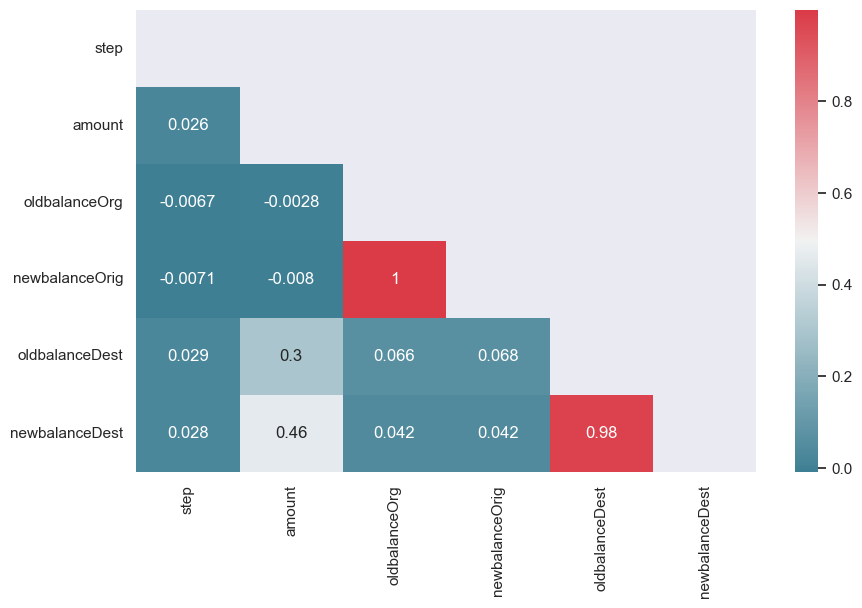

In [32]:
num_corr = numerical_att.corr()

mask = np.triu(np.ones_like(num_corr, dtype=np.bool))

fig, axes = plt.subplots(1,1,figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(num_corr, ax = axes, mask = mask, cmap=cmap, annot = True);

> Key points:
- amount and new_balance_dest: modearate positive correlation
- old_balance_orig and new_balance_orig: perfect positive correlation
- old_balance_dest and new_balance_dest: very strong positive correlation

## Correlation of categorical features

In [33]:
# instantiates a profile report
profile = ProfileReport(cat_att, title="Pandas Profiling Report for categorical attributes")

# saves report to a html file
profile.to_file("categorical_report.html")

c:\Users\pedro\miniconda3\lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

![](img/pp_categorical_warnings.png)

As observed, we have values that are constant, have high cardinality and high correlated with each other. Thus, this tells us:

- **Constant value:** we can drop this feature as this won't aggregate any information for our ML model.
- **High cardinality:** we need to choose the most appropriate categorical encoding strategy.
- **High correlation:** we can drop some features and keep other in order to remove colinearity.
- **Uniform:** we need to keep an eye on this because it can mean the presence of a **high cardinality**.

#### Cramér's V - categorical correlations

![](img/pp_categorical_correlations.png)

In [19]:
cat_att

,type,nameOrig,nameDest,orig_type,dest_type,transaction_direction
0,CASH_OUT,C101180121,C349308900,customer,customer,C2C
1,PAYMENT,C1360383837,M839082,customer,machine,C2M
2,TRANSFER,C1238026900,C1351969477,customer,customer,C2C
3,PAYMENT,C861048591,M1173719543,customer,machine,C2M
4,PAYMENT,C441181193,M78855040,customer,machine,C2M
...,...,...,...,...,...,...
6260526,TRANSFER,C390809517,C1817850202,customer,customer,C2C
6260527,CASH_OUT,C1233845935,C899674207,customer,customer,C2C
6260528,CASH_OUT,C1513064965,C1686203571,customer,customer,C2C
6260529,TRANSFER,C526265092,C217951439,customer,customer,C2C


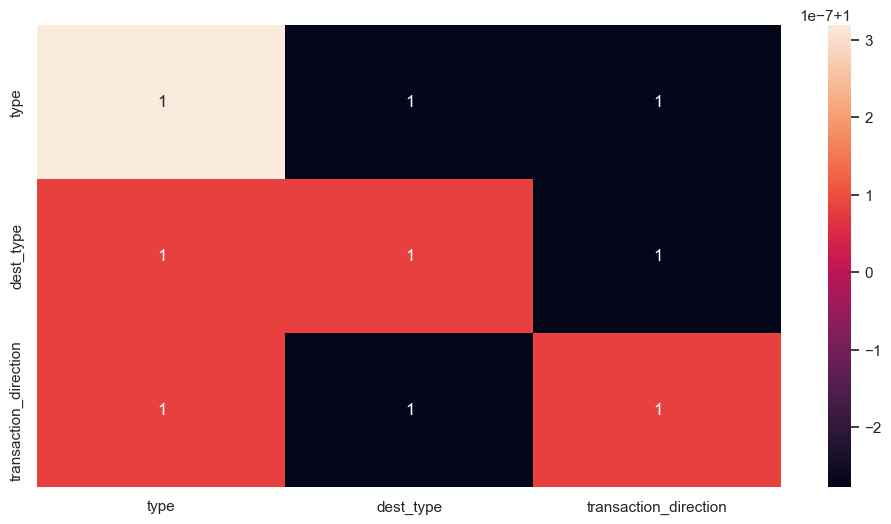

In [21]:
a1 = cramer_v(cat_att['type'], cat_att['type'])
a2 = cramer_v(cat_att['type'], cat_att['transaction_direction'])
a3 = cramer_v(cat_att['type'], cat_att['dest_type'])

a4 = cramer_v(cat_att['dest_type'], cat_att['dest_type'])
a5 = cramer_v(cat_att['dest_type'], cat_att['type'])
a6 = cramer_v(cat_att['dest_type'], cat_att['transaction_direction'])

a7 = cramer_v(cat_att['transaction_direction'], cat_att['transaction_direction'])
a8 = cramer_v(cat_att['transaction_direction'], cat_att['dest_type'])
a9 = cramer_v(cat_att['transaction_direction'], cat_att['type'])

d = pd.DataFrame( {'type':[a1,a2,a3],
        'dest_type':[a4,a5,a6],
        'transaction_direction':[a7,a8,a9]})

d = d.set_index(d.columns)

fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.heatmap(d, annot = True, ax = axes);

As observed, all the categorical attributes presents perfect positive correlations with each other. This means we'll need to drop some of them while keeping others.

# Data Preparation

In [8]:
print('Population size: {}'.format(df2.shape[0]))

Population size: 6260531


To make a right sampling we need:

- Keep the classes proportions
- Get a statistically significant sample size

Let's use the following parameters:

- **Population size:** 6,260,531 (that's the full data set size)
- **Confidence level:** 95% (that's industry standard)
- **Margin of error:** 0.1%

Making the calculations with these parameters it gives us a sample size of 832,665. Let's round up to 1,000,000 to make our lives easier.

More info at: https://www.surveymonkey.com/mp/sample-size-calculator/

In [9]:
sample_size = 1000000

In [10]:
df_frac = df2.sample(n = sample_size)

old_ratio = df2.loc[df2['isFraud'] == 1].shape[0] / df2.shape[0]
new_ratio = df_frac.loc[df_frac['isFraud'] == 1].shape[0] / df_frac.shape[0]

print('Before: {} and After: {}'.format(old_ratio,new_ratio))

Before: 0.0012933407725319146 and After: 0.001292


In [11]:
# to gauarantee the proportions and be more similar to the full dataset, we gonna select all frauds from origianl df and concatenate with non_frauds
fraud_orig = df2.loc[df2['isFraud'] == 1]
non_fraud = df_frac.loc[df_frac['isFraud'] == 0]

df_frac_final = pd.concat([non_fraud, fraud_orig], axis = 0, ignore_index = True)

In [12]:
# shuffles the data set
df_frac_final = shuffle(df_frac_final)

# resets the index
df_frac_final.reset_index(drop=True, inplace=True)

In [14]:
df_frac_final.to_parquet('../data/processed/sample_1MM_transactions.parquet', index = False)

In [15]:
try:
    del df
    del df1
    del df2
except:
    pass

In [16]:
df3 = pd.read_parquet('../data/processed/sample_1MM_transactions.parquet')

## Pre Processing

In [22]:
df3.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_type,dest_type,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new,transaction_direction,is_orig_equal_dest,hour
0,323,PAYMENT,15149.02,C1478459044,30481.00,15331.98,M565042013,0.00,0.00,0,0,customer,machine,non zero,non zero,zero,zero,no,yes,C2M,no,10
1,164,PAYMENT,5281.88,C142899801,94870.46,89588.58,M674165049,0.00,0.00,0,0,customer,machine,non zero,non zero,zero,zero,no,yes,C2M,no,19
2,522,PAYMENT,2838.59,C608764994,47344.00,44505.41,M1021075618,0.00,0.00,0,0,customer,machine,non zero,non zero,zero,zero,no,yes,C2M,no,17


In [23]:
df_target = df3[['isFraud']]

In [24]:
num_df = df3.select_dtypes(include=['int64','float64']).copy()
num_df = num_df.drop(['isFraud','isFlaggedFraud'], axis = 1)
num_df.head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,323,15149.02,30481.00,15331.98,0.00,0.00
1,164,5281.88,94870.46,89588.58,0.00,0.00
2,522,2838.59,47344.00,44505.41,0.00,0.00


In [29]:
cat_df = df3[['type', 'orig_type','dest_type', 'transaction_direction','nameOrig', 'nameDest']] #
cat_df.head(3)

,type,orig_type,dest_type,transaction_direction,nameOrig,nameDest
0,PAYMENT,customer,machine,C2M,C1478459044,M565042013
1,PAYMENT,customer,machine,C2M,C142899801,M674165049
2,PAYMENT,customer,machine,C2M,C608764994,M1021075618


In [26]:
bin_df = df3[['old_balance_orig_status', 'new_balance_orig_status','old_balance_dest_status', 'new_balance_dest_status',
                'is_orig_equal_dest','is_orig_old_balance_greater_new','is_dest_old_balance_greater_new']]
bin_df.head(3)

,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_equal_dest,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new
0,non zero,non zero,zero,zero,no,no,yes
1,non zero,non zero,zero,zero,no,no,yes
2,non zero,non zero,zero,zero,no,no,yes


## Scaling

In [30]:
mms = MinMaxScaler()

In [31]:
# numerical encoding
num_df_scaled = mms.fit_transform(num_df)

joblib.dump(mms, '../references/minmax_scaler_numerical_features.pkl')
num_df_scaled = pd.DataFrame(num_df_scaled, columns = num_df.columns)
num_df_scaled.head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.43,0.00,0.00,0.00,0.00,0.00
1,0.22,0.00,0.00,0.00,0.00,0.00
2,0.70,0.00,0.00,0.00,0.00,0.00


In [34]:
# categorical encoding
cat_df_encoded = pd.get_dummies(cat_df[['orig_type','dest_type', 'transaction_direction']], 
                                prefix = ['orig','dest','td'],
                                columns = ['orig_type','dest_type','transaction_direction'])
cat_df_encoded.head(2)

,orig_customer,dest_customer,dest_machine,td_C2C,td_C2M
0,1,0,1,0,1
1,1,0,1,0,1


In [43]:
# frequency encoding
freq_encode_type = (cat_df.groupby(['type']).size())/len(cat_df)

name_orig_encode_type = (cat_df.groupby(['nameOrig']).size())/len(cat_df)

name_dest_encode_type = (cat_df.groupby(['nameDest']).size())/len(cat_df)

In [45]:
cat_df_freq_encoded = cat_df[['type', 'nameOrig', 'nameDest']].copy()

cat_df_freq_encoded['type'] = cat_df_freq_encoded['type'].apply(lambda x : freq_encode_type[x])
cat_df_freq_encoded['nameOrig'] = cat_df_freq_encoded['nameOrig'].apply(lambda x : name_orig_encode_type[x])
cat_df_freq_encoded['nameDest'] = cat_df_freq_encoded['nameDest'].apply(lambda x : name_dest_encode_type[x])

In [46]:
# binary encoding
bin_df_encoded = bin_df.copy()

for i in ['old_balance_orig_status','new_balance_orig_status','old_balance_dest_status','new_balance_dest_status']:
    bin_df_encoded[i] = bin_df_encoded[i].apply(lambda x: 1 if x == 'non zero' else 0)

for i in ['is_orig_equal_dest','is_orig_old_balance_greater_new','is_dest_old_balance_greater_new']:
    bin_df_encoded[i] = bin_df_encoded[i].apply(lambda x: 1 if x == 'yes' else 0)

bin_df_encoded.head(3)

,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_equal_dest,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new
0,1,1,0,0,0,0,1
1,1,1,0,0,0,0,1
2,1,1,0,0,0,0,1


In [47]:
df4 = pd.concat([df_target, num_df_scaled, cat_df_encoded,cat_df_freq_encoded, bin_df_encoded], axis = 1)

df4.head(3)

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,orig_customer,dest_customer,dest_machine,td_C2C,td_C2M,type,nameOrig,nameDest,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_equal_dest,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new
0,0,0.43,0.00,0.00,0.00,0.00,0.00,1,0,1,0,1,0.34,0.00,0.00,1,1,0,0,0,0,1
1,0,0.22,0.00,0.00,0.00,0.00,0.00,1,0,1,0,1,0.34,0.00,0.00,1,1,0,0,0,0,1
2,0,0.70,0.00,0.00,0.00,0.00,0.00,1,0,1,0,1,0.34,0.00,0.00,1,1,0,0,0,0,1


In [48]:
df4.to_parquet('../data/processed/sample_1MM_transactions_encoded.parquet', index = False)

# Feature Selection

In [49]:
df5 = pd.read_parquet('../data/processed/sample_1MM_transactions_encoded.parquet')
df5.head(3)

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,orig_customer,dest_customer,dest_machine,td_C2C,td_C2M,type,nameOrig,nameDest,old_balance_orig_status,new_balance_orig_status,old_balance_dest_status,new_balance_dest_status,is_orig_equal_dest,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new
0,0,0.43,0.00,0.00,0.00,0.00,0.00,1,0,1,0,1,0.34,0.00,0.00,1,1,0,0,0,0,1
1,0,0.22,0.00,0.00,0.00,0.00,0.00,1,0,1,0,1,0.34,0.00,0.00,1,1,0,0,0,0,1
2,0,0.70,0.00,0.00,0.00,0.00,0.00,1,0,1,0,1,0.34,0.00,0.00,1,1,0,0,0,0,1


### Boruta

In [50]:
# trying Boruta
X = df5.drop(['isFraud'], axis = 1).values
y = df5['isFraud'].values.ravel()

rf_clf = RandomForestClassifier(n_jobs=2)

boruta = BorutaPy(rf_clf, n_estimators='auto',verbose=2,random_state=42)

In [51]:
boruta.fit(X,y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	11
I

BorutaPy(estimator=RandomForestClassifier(n_estimators=44, n_jobs=2,
                                          random_state=RandomState(MT19937) at 0x206BCE05B40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x206BCE05B40, verbose=2)

In [52]:
# gets the ranked list of features
cols_boruta = boruta.support_.tolist()
cols_selected_boruta = df5.drop(['isFraud'], axis=1).iloc[:, cols_boruta].columns.to_list()
cols_selected_boruta

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'type',
 'new_balance_orig_status',
 'old_balance_dest_status',
 'new_balance_dest_status']

In [54]:
final_cols = cols_selected_boruta + ['isFraud']

df6 = df5[final_cols].copy()

In [56]:
df6.to_parquet('../data/processed/boruta_selected.parquet', index = False)

### Tree-Based feature importance

In [3]:
# model_rf_featured = RandomForestClassifier(n_estimators=300, max_depth = 5,min_samples_split = 5,
#                                           min_samples_leaf = 3, min_weight_fraction_leaf=0.0, n_jobs = 2, random_state=42)

# X = df5.drop(['isFraud'], axis = 1)
# y = df5[['isFraud']]

# model_rf_featured.fit(X,y)

C:\Users\u337356\AppData\Local\Temp\ipykernel_20308\793807674.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf_featured.fit(X,y)


RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=300, n_jobs=2, random_state=42)

In [17]:
# model_rf_featured.feature_names_in_.T

array(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'orig_customer', 'dest_customer', 'dest_machine', 'td_C2C',
       'td_C2M', 'old_balance_orig_status', 'new_balance_orig_status',
       'old_balance_dest_status', 'new_balance_dest_status',
       'is_orig_equal_dest', 'is_orig_old_balance_greater_new',
       'is_dest_old_balance_greater_new'], dtype=object)

In [26]:
# df_feature = pd.DataFrame()
# df_feature['variables'] = model_rf_featured.feature_names_in_
# df_feature['importance'] = model_rf_featured.feature_importances_
# df_feature.sort_values(by=['importance'], ascending = False, inplace = True)
# df_feature

,variables,importance
0,step,0.26
2,oldbalanceOrg,0.21
19,new_balance_dest_status,0.13
5,newbalanceDest,0.12
1,amount,0.08
10,type_TRANSFER,0.06
7,type_CASH_OUT,0.03
18,old_balance_dest_status,0.02
17,new_balance_orig_status,0.02
3,newbalanceOrig,0.02


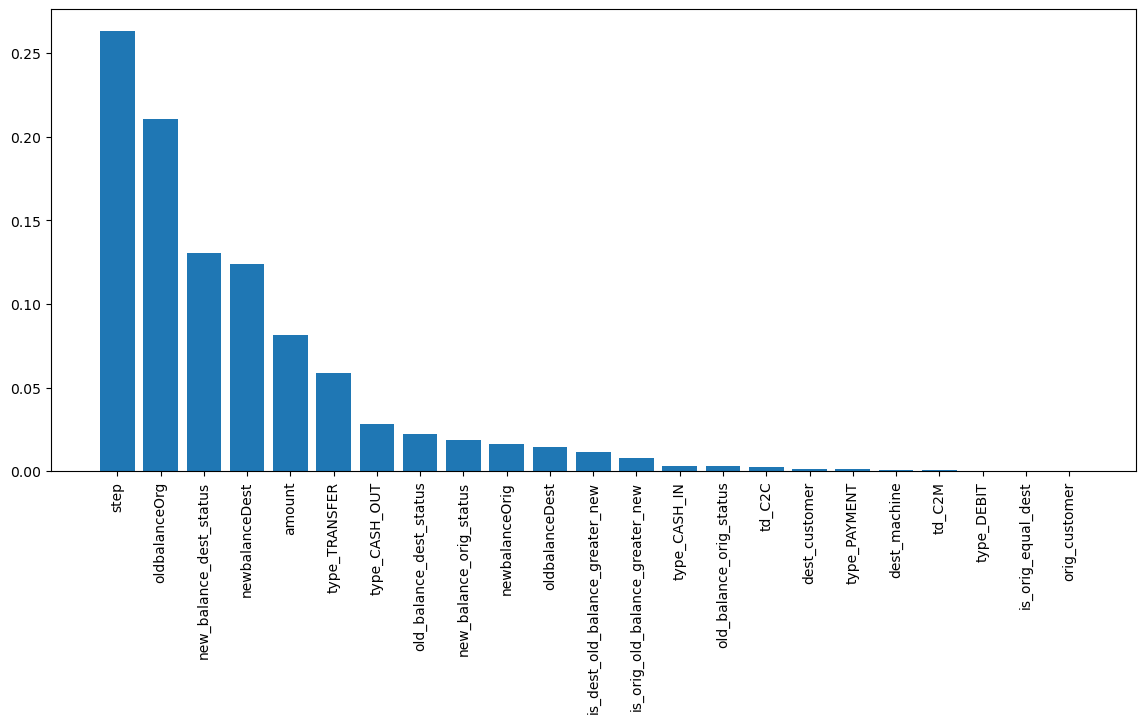

In [25]:
# plt.figure(figsize=(9,5))
# plt.subplot(1,1,1)
# plt.bar(x=df_feature['variables'], height = df_feature['importance'])
# plt.xticks(rotation = 90)
# plt.show()

In [27]:
# features_rf_selected = df_feature.loc[df_feature['importance'] >= 0.02,'variables'].values
# features_rf_selected

array(['step', 'oldbalanceOrg', 'new_balance_dest_status',
       'newbalanceDest', 'amount', 'type_TRANSFER', 'type_CASH_OUT',
       'old_balance_dest_status'], dtype=object)

In [31]:
# df6 = df5[features_rf_selected].copy()
# df6 = pd.concat( [df6, y], axis = 1)
# df6.head(3)

,step,oldbalanceOrg,new_balance_dest_status,newbalanceDest,amount,type_TRANSFER,type_CASH_OUT,old_balance_dest_status,isFraud
0,0.50,0.10,1,0.00,0.00,0,0,1,0
1,0.19,0.00,0,0.00,0.00,0,0,0,0
2,0.17,0.00,1,0.00,0.00,0,1,1,0


In [32]:
# df6.to_parquet('../data/processed/random_forest_selected.parquet', index = False)